# Package

In [ ]:
import torchvision
import torch
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# DataLoader

In [ ]:
class PrepareDataLoader():
  def __init__(self, train_path, test_path):
    self.train_path = train_path
    self.test_path = test_path

  def calculate_mean_std(self):
    train_dataset = torchvision.datasets.ImageFolder(
    self.train_path,
    transform=torchvision.transforms.Compose([
        # Resize step is required as we will use a ResNet model, which accepts at leats 224x224 images
        torchvision.transforms.Resize((224,224)),
        torchvision.transforms.ToTensor(),
      ])
    )
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

    means = []
    stdevs = []
    for X, _ in train_dataloader:
        # Dimensions 0,2,3 are respectively the batch, height and width dimensions
        means.append(X.mean(dim=(0,2,3)))
        stdevs.append(X.std(dim=(0,2,3)))
    mean = torch.stack(means, dim=0).mean(dim=0)
    stdev = torch.stack(stdevs, dim=0).mean(dim=0)

    return mean, stdev

  def get_dataset(self):
    mean, stdev = self.calculate_mean_std()

    train_transforms = torchvision.transforms.Compose([
            torchvision.transforms.Resize((224,224)),
            torchvision.transforms.AutoAugment(policy=torchvision.transforms.AutoAugmentPolicy.CIFAR10),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean, stdev)
        ])


    test_transforms = torchvision.transforms.Compose([
            torchvision.transforms.Resize((224,224)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean, stdev)
        ])

    train_dataset = torchvision.datasets.ImageFolder(self.train_path, transform=train_transforms)
    test_dataset = torchvision.datasets.ImageFolder(self.test_path, transform=test_transforms)

    return train_dataset, test_dataset

  def prepare_dataloader(self, get_dataset = False):
    train_dataset, test_dataset = self.get_dataset()

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, pin_memory=True)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)


    return train_dataloader, test_dataloader

In [ ]:
DataLoader = PrepareDataLoader(train_path='/content/drive/MyDrive/dataset/train', test_path='/content/drive/MyDrive/dataset/test')

In [ ]:
train_dataloader, test_dataloader = DataLoader.prepare_dataloader()

# Build model

In [ ]:
class_name_path = "/content/drive/MyDrive/dataset/train"
ClassName = os.listdir(class_name_path)

In [ ]:
def get_net(pretrain = False):
  if pretrain:
    resnet = torchvision.models.resnet50(weights="ResNet50_Weights.IMAGENET1K_V1")
  else:
    resnet = torchvision.models.resnet50(weights=None)

  # Substitute the FC output layer
  resnet.fc = torch.nn.Linear(resnet.fc.in_features, len(ClassName))
  torch.nn.init.xavier_uniform_(resnet.fc.weight)
  return resnet

In [ ]:
def train(net, train_dataloader, valid_dataloader, criterion, optimizer, scheduler=None, epochs=10, device='cpu', checkpoint_epochs=10, is_cv = False):
    print(f'Training for {epochs} epochs on {device}')
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(1,epochs+1):
        net.train()  # put network in train mode for Dropout and Batch Normalization
        train_loss = torch.tensor(0., device=device)  # loss and accuracy tensors are on the GPU to avoid data transfers
        train_accuracy = torch.tensor(0., device=device)
        for X, y in train_dataloader:
            X = X.to(device)
            y = y.to(device)
            preds = net(X)
            train_loss = criterion(preds, y)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            with torch.no_grad():
                train_loss += train_loss * train_dataloader.batch_size
                train_accuracy += (torch.argmax(preds, dim=1) == y).sum()

        train_losses.append((train_loss/len(train_dataloader.dataset)).item())
        train_accuracies.append((100*train_accuracy/len(train_dataloader.dataset)).item())

        if valid_dataloader is not None:
            net.eval()  # put network in train mode for Dropout and Batch Normalization
            valid_loss = torch.tensor(0., device=device)
            valid_accuracy = torch.tensor(0., device=device)
            with torch.no_grad():
                for X, y in valid_dataloader:
                    X = X.to(device)
                    y = y.to(device)
                    preds = net(X)
                    val_loss = criterion(preds, y)

                    valid_loss += val_loss * valid_dataloader.batch_size
                    valid_accuracy += (torch.argmax(preds, dim=1) == y).sum()

        val_losses.append((valid_loss/len(valid_dataloader.dataset)).item())
        val_accuracies.append((100*valid_accuracy/len(valid_dataloader.dataset)).item())

        if scheduler is not None:
            scheduler.step()

        # saving & print result
        if is_cv: # cross validation
          if epoch%checkpoint_epochs==0:
            print(f"Epoch {epoch}/{epochs}")
            print(f'Training loss: {train_loss/len(train_dataloader.dataset):.2f}')
            print(f'Training accuracy: {100*train_accuracy/len(train_dataloader.dataset):.2f}')
            print(f'Valid loss: {valid_loss/len(valid_dataloader.dataset):.2f}')
            print(f'Valid accuracy: {100*valid_accuracy/len(valid_dataloader.dataset):.2f}')
            print()

        else: # training
          print(f"Epoch {epoch}/{epochs}")
          print(f'Training loss: {train_loss/len(train_dataloader.dataset):.2f}')
          print(f'Training accuracy: {100*train_accuracy/len(train_dataloader.dataset):.2f}')

          if valid_dataloader is not None:
              print(f'Valid loss: {valid_loss/len(valid_dataloader.dataset):.2f}')
              print(f'Valid accuracy: {100*valid_accuracy/len(valid_dataloader.dataset):.2f}')
          print()

          if epoch%checkpoint_epochs==0:
            torch.save({
                'epoch': epoch,
                'state_dict': net.state_dict(),
                'optimizer': optimizer.state_dict(),
            }, './checkpoint.resnet50_.pth')

    return net, train_losses, train_accuracies, val_losses, val_accuracies

# Train

### Hyperparameter

In [ ]:
lr = 1e-4
weight_decay = 5e-4
epochs = 100
criterion = torch.nn.CrossEntropyLoss()
pretrain = False

# params_1x are the parameters of the network body, i.e., of all layers except the FC layers
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = get_net(pretrain=pretrain).to(device)
params_1x = [param for name, param in net.named_parameters() if 'fc' not in str(name)]
optimizer = torch.optim.Adam([{'params':params_1x}, {'params': net.fc.parameters(), 'lr': lr*10}], lr = lr, weight_decay=weight_decay)

### training

In [ ]:
net, train_losses, train_accuracies, test_losses, test_accuracies = train(net, train_dataloader, test_dataloader, criterion, optimizer, None, epochs, device, is_cv = False)

Training for 100 epochs on cuda
Epoch 1/100
Training loss: 0.17
Training accuracy: 27.25
Valid loss: 4.11
Valid accuracy: 20.00

Epoch 2/100
Training loss: 0.14
Training accuracy: 29.00
Valid loss: 3.63
Valid accuracy: 20.00

Epoch 3/100
Training loss: 0.11
Training accuracy: 42.00
Valid loss: 2.94
Valid accuracy: 21.00

Epoch 4/100
Training loss: 0.13
Training accuracy: 41.00
Valid loss: 1.82
Valid accuracy: 33.00

Epoch 5/100
Training loss: 0.12
Training accuracy: 43.25
Valid loss: 2.09
Valid accuracy: 48.00

Epoch 6/100
Training loss: 0.09
Training accuracy: 42.75
Valid loss: 1.31
Valid accuracy: 51.00

Epoch 7/100
Training loss: 0.14
Training accuracy: 49.50
Valid loss: 1.44
Valid accuracy: 54.00

Epoch 8/100
Training loss: 0.07
Training accuracy: 46.75
Valid loss: 1.37
Valid accuracy: 55.00

Epoch 9/100
Training loss: 0.09
Training accuracy: 50.25
Valid loss: 1.52
Valid accuracy: 36.00

Epoch 10/100
Training loss: 0.09
Training accuracy: 47.50
Valid loss: 1.96
Valid accuracy: 47.0

### visualize

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
class Result():
  def __init__(self, y_pred, y_test, ClassName):
    self.y_pred = y_pred
    self.y_test = y_test
    self.ClassName = ClassName

  def get_accuracy(self):
    return accuracy_score(self.y_pred, self.y_test)*100

  def get_cm(self):
    return confusion_matrix(self.y_test, self.y_pred)

  def plot_cm(self):
    cm = self.get_cm()
    cm_df = pd.DataFrame(cm, index = self.ClassName, columns = self.ClassName)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Ground Truth')
    plt.xlabel('Predicted')
    plt.show()

  def get_recall_f1score_precision(self):
    f1_Score = f1_score(self.y_test, self.y_pred, average = None).reshape(len(ClassName), -1)
    recall = recall_score(self.y_test, self.y_pred, average = None).reshape(len(ClassName), -1)
    precision = precision_score(self.y_test, self.y_pred, average = None).reshape(len(ClassName), -1)

    result = np.concatenate((f1_Score, recall, precision), axis = 1)
    df_result = pd.DataFrame(result)
    df_result.columns = ["f1_score", "recall", "precision"]
    df_result.index = self.ClassName
    print(df_result)

  def plot_every_metrix(self):
    print(f"The accuracy is {self.get_accuracy()}")
    print()

    self.get_recall_f1score_precision()
    print()

    self.plot_cm()
    print()


In [ ]:
def plot_loss(train_losses, test_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(test_losses)), test_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
def plot_accuracy(train_accuracies, test_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)), train_accuracies, label='Training Accuracy')
    plt.plot(range(len(test_accuracies)), test_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

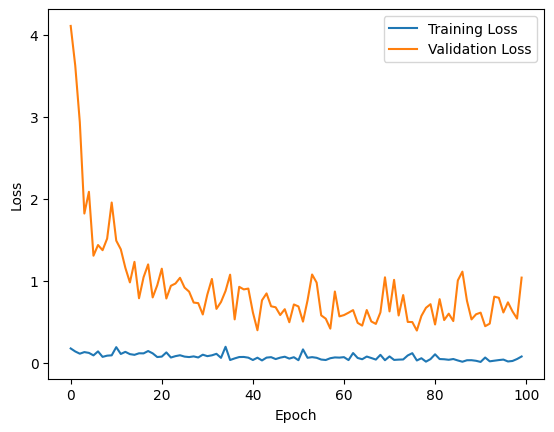

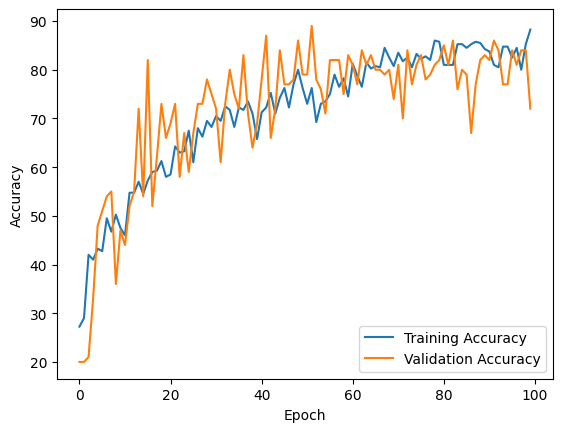

In [ ]:
plot_loss(train_losses, test_losses)
plot_accuracy(train_accuracies, test_accuracies)

The accuracy is 72.0

                     f1_score  recall  precision
traffic_light        0.518519    0.35   1.000000
zebra_crossing       0.900000    0.90   0.900000
double_yellow_lines  0.523810    0.55   0.500000
nothing              0.769231    1.00   0.625000
bus                  0.820513    0.80   0.842105



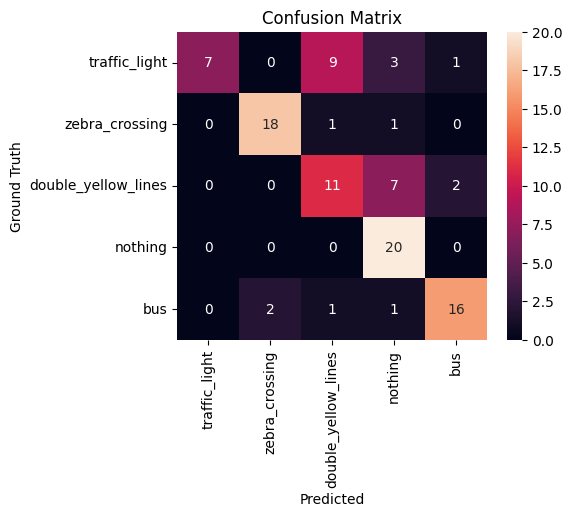

In [ ]:
model = get_net(pretrain=pretrain).to(device)
model.load_state_dict(torch.load("/content/checkpoint.resnet50_.pth")['state_dict'])

y_test = []
y_pred = []

model.eval()
with torch.no_grad():
  for x, y in test_dataloader:
    x = x.to(device)
    preds = model(x)
    pred = torch.argmax(preds, dim=1)

    y_test += y.tolist()
    y_pred += pred.tolist()

result = Result(y_pred, y_test, ClassName)
result.plot_every_metrix()

# Cross Validation

In [ ]:
DataLoader = PrepareDataLoader(train_path='/content/drive/MyDrive/dataset/train', test_path='/content/drive/MyDrive/dataset/test')

In [ ]:
train_dataset, test_dataset = DataLoader.get_dataset()

### hyperparameter

In [ ]:
lr = 1e-4
weight_decay = 5e-4
epochs = 10
criterion = torch.nn.CrossEntropyLoss()
pretrain = True

# params_1x are the parameters of the network body, i.e., of all layers except the FC layers
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = get_net(pretrain=pretrain).to(device)
params_1x = [param for name, param in net.named_parameters() if 'fc' not in str(name)]
optimizer = torch.optim.Adam([{'params':params_1x}, {'params': net.fc.parameters(), 'lr': lr*10}], lr = lr, weight_decay=weight_decay)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 173MB/s]


### cross validation

In [ ]:
k_folds = 5
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

kf = KFold(n_splits=k_folds, shuffle=True)
for fold, (train_idx, test_idx) in enumerate(kf.split(train_dataset)):
    print(f"Fold {fold + 1}")
    print("-------")

    # Define the data loaders for the current fold
    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        sampler=torch.utils.data.SubsetRandomSampler(train_idx),
    )
    test_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        sampler=torch.utils.data.SubsetRandomSampler(test_idx),
    )

    net, train_losses, train_accuracies, test_losses, test_accuracies = train(net, train_dataloader, test_dataloader,
                                            criterion, optimizer, None, epochs, device,
                                            checkpoint_epochs = 5, is_cv=True)

Fold 1
-------
Training for 10 epochs on cuda
Epoch 5/10
Training loss: 0.02
Training accuracy: 96.50
Valid loss: 0.04
Valid accuracy: 98.00

Epoch 10/10
Training loss: 0.01
Training accuracy: 97.00
Valid loss: 0.05
Valid accuracy: 98.00

Fold 2
-------
Training for 10 epochs on cuda
Epoch 5/10
Training loss: 0.01
Training accuracy: 98.25
Valid loss: 0.12
Valid accuracy: 97.00

Epoch 10/10
Training loss: 0.00
Training accuracy: 98.25
Valid loss: 0.17
Valid accuracy: 95.00

Fold 3
-------
Training for 10 epochs on cuda
Epoch 5/10
Training loss: 0.01
Training accuracy: 97.75
Valid loss: 0.07
Valid accuracy: 96.00

Epoch 10/10
Training loss: 0.00
Training accuracy: 99.00
Valid loss: 0.11
Valid accuracy: 96.00

Fold 4
-------
Training for 10 epochs on cuda
Epoch 5/10
Training loss: 0.00
Training accuracy: 98.75
Valid loss: 0.12
Valid accuracy: 97.00

Epoch 10/10
Training loss: 0.00
Training accuracy: 99.00
Valid loss: 0.19
Valid accuracy: 95.00

Fold 5
-------
Training for 10 epochs on cud